# Download Steam Banners

Code inspired from https://github.com/woctezuma/download-steam-banners

## Setting

Mount Google Drive

In [0]:
from google.colab import drive

mount_folder = '/content/gdrive'
drive.mount(mount_folder)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Go into the working directory

In [0]:
import os

app_folder = mount_folder + '/My Drive/'
os.chdir(app_folder)

Install Python requirements

In [0]:
!pip install aiofiles aiohttp steamspypi

Input

In [0]:
import steamspypi

def get_app_ids_file_name():
  return 'app_ids.txt'

def create_app_id_list():
  data = steamspypi.load()
  
  with open(get_app_ids_file_name(), 'w') as f:
    for app_id in sorted(list(data.keys()), key=int):
      f.write(str(app_id) + '\n')

def get_app_ids():
    with open(get_app_ids_file_name(), 'r') as f:
      app_ids = [int(app_id.strip()) for app_id in f.readlines()]
    return app_ids

Data source

In [0]:
def get_banner_url(app_id):
  return 'https://steamcdn-a.akamaihd.net/steam/apps/' + str(app_id) + '/header.jpg'

Output

In [0]:
from pathlib import Path

def get_banner_folder(prefixe = 'original'):
  banner_folder = 'data/'+prefixe+'_steam_banners/'
  Path(banner_folder).mkdir(exist_ok=True)  
  return banner_folder

def get_file_extension():
  return '.jpg'
  
def get_banner_file_name(app_id):
  return get_banner_folder() + str(app_id) + get_file_extension()

## Download Steam banners

**Caveat**: there are about 30,000 banners to download!

In [0]:
import asyncio
import aiofiles
import aiohttp

async def main():
    async with aiohttp.ClientSession() as session:

        for app_id in sorted(get_app_ids()):
            banner_file_name = Path(get_banner_file_name(app_id))

            if banner_file_name.exists():
                continue

            banner_url = get_banner_url(app_id)

            # Reference: https://stackoverflow.com/a/51745925
            async with session.get(banner_url) as resp:
                if resp.status == 200:
                    f = await aiofiles.open(banner_file_name, mode='wb')
                    await f.write(await resp.read())
                    await f.close()
                    print('Banner downloaded to {} for appID {}.'.format(banner_file_name, app_id))
                else:
                    print('Banner for appID {} could not be downloaded.'.format(app_id))


In [0]:
create_app_id_list()

loop = asyncio.get_event_loop()
loop.run_until_complete(main())

Banner for appID 852 could not be downloaded.
Banner for appID 8955 could not be downloaded.
Banner for appID 13120 could not be downloaded.
Banner for appID 13260 could not be downloaded.
Banner for appID 17760 could not be downloaded.
Banner for appID 25730 could not be downloaded.
Banner for appID 29017 could not be downloaded.
Banner for appID 35470 could not be downloaded.
Banner for appID 46470 could not be downloaded.
Banner for appID 55190 could not be downloaded.
Banner for appID 55210 could not be downloaded.
Banner for appID 63230 could not be downloaded.
Banner for appID 71300 could not be downloaded.
Banner for appID 71310 could not be downloaded.
Banner for appID 72520 could not be downloaded.
Banner for appID 72530 could not be downloaded.
Banner for appID 98810 could not be downloaded.
Banner for appID 99110 could not be downloaded.
Banner for appID 99930 could not be downloaded.
Banner for appID 102210 could not be downloaded.
Banner for appID 201930 could not be downl

## Post-processing appIDs

AppIDs for which a Steam banner was effectively downloaded:

In [0]:
import glob

def get_app_ids_with_steam_banners():
    image_filenames = Path(get_banner_folder()).glob('*' + get_file_extension())

    app_ids = [banner.name.strip(get_file_extension()) for banner in image_filenames]
    
    # There is an issue with duplicates, e.g. 'ABC (1).jpg' but only when running on Google Drive:
    app_ids = [app_id for app_id in app_ids if ' (' not in app_id]

    app_ids = [int(app_id) for app_id in app_ids]
    
    return app_ids

Compare the number appIDs in SteamSpy database with the number of banners saved to disk

In [0]:
create_app_id_list()     

app_ids = get_app_ids()
print('#appIDs in SteamSpy database = {}'.format(len(app_ids)))

app_ids_with_steam_banners = get_app_ids_with_steam_banners()
print('#banners saved to disk = {}'.format(len(app_ids_with_steam_banners)))

#appIDs in SteamSpy database = 28019
#banners saved to disk = 27974


Omit appIDs for which a banner could not be found

In [0]:
def trim_app_id_list():
  app_ids = get_app_ids()
  
  app_ids_with_steam_banners = get_app_ids_with_steam_banners()
  
  common_app_ids = set(app_ids).intersection(app_ids_with_steam_banners) 
  
  with open(get_app_ids_file_name(), 'w') as f:
    for app_id in sorted(common_app_ids, key=int):
      f.write(str(app_id) + '\n')   

In [0]:
create_app_id_list()    
trim_app_id_list()     

app_ids = get_app_ids()
print('#appIDs in SteamSpy database, and with a banner saved to disk = {}'.format(len(app_ids)))

#appIDs in SteamSpy database, and with a banner saved to disk = 27974


## Post-processing Steam banners

Create a folder where banners resized to square proportions will be stored

In [0]:
prefixe = 'resized'

Path('data/'+prefixe+'_steam_banners/').mkdir(exist_ok=True)

Function to read banner names

In [0]:
def get_banner_names(prefixe='original'):
  banner_names = [Path(f).name for f in glob.glob('data/'+prefixe+'_steam_banners/*.jpg')]
  return banner_names

Find banners which were downloaded but not yet resized

In [0]:
def find_new_banners():
  l_original = get_banner_names('original')
  l_resized = get_banner_names('resized')

  l_new = set(l_original).difference(l_resized)

  app_ids_new = [int(app_id.strip(get_file_extension())) for app_id in l_new]
  
  print('#banners downloaded but not yet resized = {}'.format(len(app_ids_new)))
  
  return app_ids_new

Handle a log file with appIDs of banners which have yet to be resized

In [0]:
def get_copy_and_resize_todo_file_name():
  return 'copy_and_resize_todo.txt'

def create_copy_and_resize_todo():
  
  app_ids_new = find_new_banners()
  
  with open(get_copy_and_resize_todo_file_name(), 'w') as f:
    for app_id in app_ids_new:
      f.write(str(app_id) + '\n')

  return

def load_copy_and_resize_todo():

  with open(get_copy_and_resize_todo_file_name(), 'r') as f:
      app_ids = [int(app_id.strip()) for app_id in f.readlines()]
  
  return app_ids

In [0]:
create_copy_and_resize_todo() 

#banners downloaded but not yet resized = 0


Install ImageMagick

In [0]:
!apt-get install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.4).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


Resize banners from 215x460 pixels to 215x215 pixels

**Caveat: this process is extremely fast [if run locally](https://github.com/woctezuma/download-steam-banners/blob/master/batch_resize_images.py), and is extremely slow if run on the cloud!**

In [0]:
for app_id in load_copy_and_resize_todo():
  !echo convert data/original_steam_banners/{app_id}.jpg -resize '215x215!' data/resized_steam_banners/{app_id}.jpg
  !convert data/original_steam_banners/{app_id}.jpg -resize '215x215!' data/resized_steam_banners/{app_id}.jpg

Manually check one banner

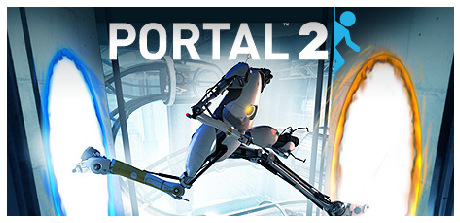

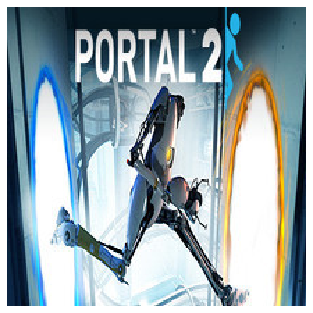

In [0]:
import cv2
from matplotlib import pyplot as plt

app_id = 620

for prefixe in ['original', 'resized']:
  img = cv2.imread('data/' + prefixe + '_steam_banners/'+str(app_id)+'.jpg')

  plt.imshow(img[..., ::-1])
  plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
  plt.show()

Automatically check every banner. Caveat: this is slow and optional!

In [0]:
import cv2

app_ids_to_resize = []
counters = {'original':0, 'resized':0}

for counter, app_id in enumerate(get_app_ids()):
  img = cv2.imread('data/resized_steam_banners/'+str(app_id)+'.jpg')
  
  if img is None:
    print('Missing banner for appID = {}'.format(app_id))
    continue
  
  if img.shape[0] != img.shape[1]:    
    print('Non-square banner size for appID = {}'.format(app_id))
    app_ids_to_resize.append(app_id)
    counters['original'] += 1
  else:
    counters['resized'] += 1

  if (counter+1) % 100 == 0:
    print('Current counters: {}'.format(counters))    

Ensure that the banners which had slipped through the resize process somehow are resized.

**Caveat: this process is extremely fast [if run locally](https://github.com/woctezuma/download-steam-banners/blob/master/batch_resize_images.py), and is extremely slow if run on the cloud!**

In [0]:
for counter, app_id in enumerate(app_ids_to_resize):  
  img = cv2.imread('data/resized_steam_banners/'+str(app_id)+'.jpg')
   
  if img.shape[0] != img.shape[1]: 
    !echo mogrify -resize '215x215!' data/resized_steam_banners/{app_id}.jpg
    !mogrify -resize '215x215!' data/resized_steam_banners/{app_id}.jpg
  else:
    continue

  if (counter+1) % 100 == 0:
    print('{} images processed'.format(counter+1))